In [478]:
### Import all the dependencies 
import warnings
warnings.filterwarnings('ignore')
import requests
import csv
import json
import pandas as pd
import re


In [479]:
### Main Program starts here  - Now we will read data from CSV

external_customers_df = pd.read_csv("../data/external_customers.csv", low_memory=False)
print('Shape of exports read from CSV : {}'.format(external_customers_df.shape))

Shape of exports read from CSV : (53906, 16)


In [480]:
##List the names of columns 
external_customers_df.columns


Index(['Unnamed: 0', 'Domain', 'UserEmail', 'serviceName', 'UserId', 'IndvId',
       'SessionId', 'PageUrl', 'PageRefererUrl', 'PageBrowser', 'PageDevice',
       'PageDuration', 'PageActiveDuration', 'PageLatLong', 'EventStart',
       'EventType'],
      dtype='object')

In [481]:
len(external_customers_df.columns)

16

In [482]:
## Data Cleaning and filtering 
#Dropping an column not needed 
print('Number of columns before :{}'.format(len(external_customers_df.columns)))
external_customers_df.drop('Unnamed: 0', axis=1, inplace=True)
print('Number of columns after :{}'.format(len(external_customers_df.columns)))

Number of columns before :16
Number of columns after :15


In [401]:
# Quick preview of data
external_customers_df.head()   


,Domain,UserEmail,serviceName,UserId,IndvId,SessionId,PageUrl,PageRefererUrl,PageBrowser,PageDevice,PageDuration,PageActiveDuration,PageLatLong,EventStart,EventType
0,Company1.com,chad.tew@Company1.com,Data Logging,5650932471693312,5650932471693312,5629499534213120,https://www.cloud.dataguru.com/li/,https://console.cloud.dataguru.com/bin/gateway...,Chrome,Desktop,20030,3459,"33.3335,-86.9591",2018-09-08T23:10:55.257Z,navigate
1,Company1.com,chad.tew@Company1.com,Data Logging,5650932471693312,5650932471693312,5629499534213120,https://www.cloud.dataguru.com/li/,https://console.cloud.dataguru.com/bin/gateway...,Chrome,Desktop,20030,3459,"33.3335,-86.9591",2018-09-08T23:10:56.231Z,load
2,Company1.com,chad.tew@Company1.com,Data Logging,5650932471693312,5650932471693312,5629499534213120,https://www.cloud.dataguru.com/li/,https://console.cloud.dataguru.com/bin/gateway...,Chrome,Desktop,20030,3459,"33.3335,-86.9591",2018-09-08T23:11:15.045Z,click
3,Company2.com,mike.hutt@Company2.com,SDK,5746562451898368,5767773206609920,5629499534213120,https://www.cloud.dataguru.com/catalog/#/library,https://console.cloud.dataguru.com/bin/gateway...,Chrome,Desktop,2038981,249088,"48.8628,2.3292",2018-09-10T09:33:03.950Z,navigate
4,Company2.com,mike.hutt@Company2.com,SDK,5746562451898368,5767773206609920,5629499534213120,https://www.cloud.dataguru.com/catalog/#/library,https://console.cloud.dataguru.com/bin/gateway...,Chrome,Desktop,2038981,249088,"48.8628,2.3292",2018-09-10T09:33:04.026Z,load


In [483]:
# AS Cell

## Now we need to answer active users or company by unique session ID count 
df_groupby_session = external_customers_df.groupby(["Domain","UserEmail"])["UserId"].nunique()
df_groupby_session


Domain         UserEmail                        
Company1.com   chad.tew@Company1.com                 3
Company10.com  james.knueven@Company10.com           9
               jaroslaw.gajewski@Company10.com       2
               konrad.clapa@Company10.com            4
               robert.nieman@Company10.com           6
Company11.com  joshua.broadway@Company11.com         3
Company12.com  zach.milleson@Company12.com          11
Company13.com  abdul.kazmi@Company13.com             1
               michael.phillips@Company13.com        1
Company14.com  akardell@Company14.com                6
               bmiller@Company14.com                 1
               gthompson@Company14.com               1
Company15.com  asmith1@Company15.com                 4
               bianca1@Company15.com                 1
Company16.com  czoller@Company16.com                 5
Company17.com  marcus.schoen@Company17.com          14
Company18.com  aghasigevorgyan@Company18.com         4
Company19.com  j

In [484]:
# AS Cell

# Setting data for Active Customers by Session 

df_groupby_session = external_customers_df.groupby(["Domain"])['UserId'].nunique()
df_groupby_session = df_groupby_session.sort_values(ascending=False)
company_bysession_df = df_groupby_session.reset_index(['Domain'])
company_bysession_df = company_bysession_df.rename(columns={"UserId": "SessionCount"})
# Saving in another df in case we need to use it later  --Can be removed later
company_bysession_df_saved = company_bysession_df
# Removing outliers 
company_bysession_df = company_bysession_df[company_bysession_df['SessionCount']>2]
company_bysession_df.head()

,Domain,SessionCount
0,Company9.com,41
1,Company43.com,39
2,Company24.com,36
3,Company46.com,23
4,Company10.com,21


In [485]:
# AS Cell  

## Top 15 Active Cutomers By Session
company_bysession_df = company_bysession_df.head(15)
company_bysession_df

,Domain,SessionCount
0,Company9.com,41
1,Company43.com,39
2,Company24.com,36
3,Company46.com,23
4,Company10.com,21
5,Company36.com,17
6,Company50.com,17
7,Company22.com,15
8,Company17.com,14
9,Company38.com,14


In [486]:
# Importing dependencies
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from palettable.colorbrewer.qualitative import Pastel1_7  # Inferno_4,Plasma_5,Viridis_6,Viridis_4 

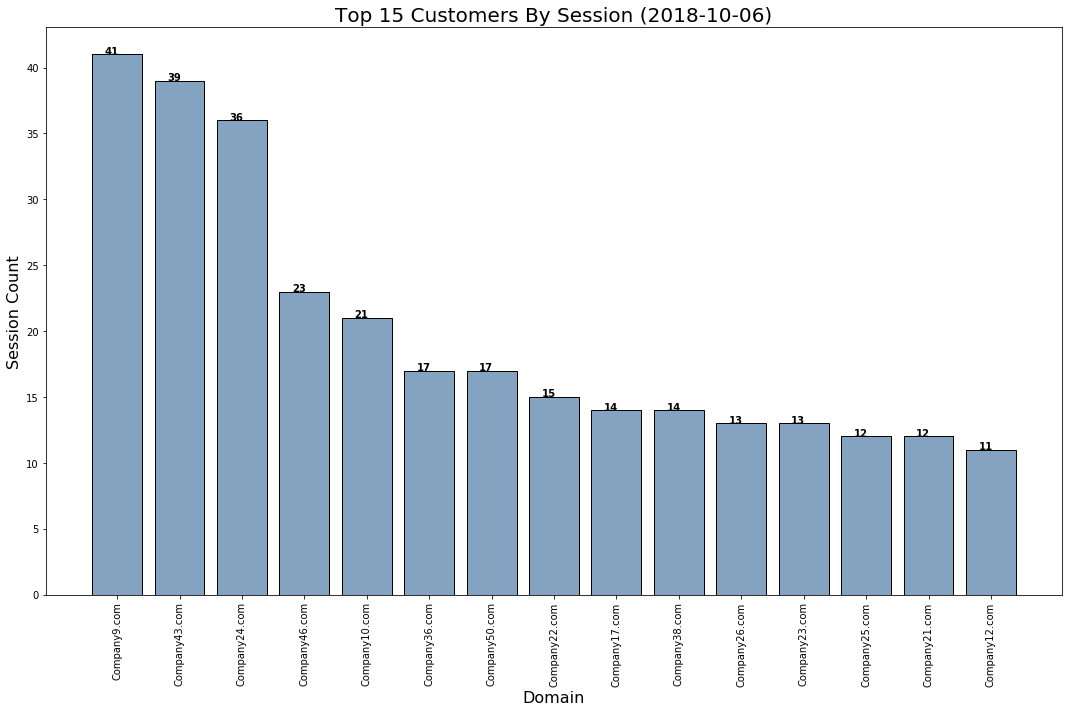

In [407]:
# AS Cell

# Visually answering Top 15 Customers by Sessions  

# Plotting the graph
plt.figure(figsize=(15,10))
y_pos = np.arange(len(company_bysession_df["Domain"]))
plt.bar(y_pos, company_bysession_df["SessionCount"], color=(0.2, 0.4, 0.6, 0.6), edgecolor = 'black' )
plt.xticks(y_pos, company_bysession_df["Domain"], rotation='vertical')
# Setting value label for each bar
for i, v in enumerate(company_bysession_df["SessionCount"]):
    plt.text(i-.20, v+.020, v, color='black', fontweight='bold')
# Setting title, grid and X and Y axis labels
plt.xlabel("Domain",fontsize=16)
plt.ylabel("Session Count", fontsize=16)
plt.title(f'Top 15 Customers By Session ({datetime.now().date()})', fontsize=20)
plt.tight_layout()
# Save Figure
plt.savefig("../imgs/Top15CustomerBySession.png")
plt.show()


In [487]:
# AS Cell

## Now we need to answer most used service 

# Setting data for most used services
most_used_services_df = external_customers_df.groupby(["serviceName"])["PageUrl"].count()
most_used_services_df = most_used_services_df.reset_index(['serviceName'])
most_used_services_df = most_used_services_df.rename(columns={"PageUrl": "PageUrlCount"})
most_used_services_df

,serviceName,PageUrlCount
0,Data Logging,3576
1,Data Package,40931
2,SDK,9399


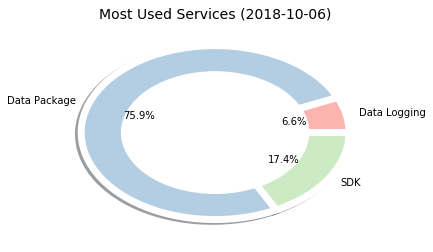

In [488]:
# AS Cell 

# Visually answering Most Used Services

# Plotting the graph
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(most_used_services_df["PageUrlCount"], labels=most_used_services_df["serviceName"], wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' }, colors=Pastel1_7.hex_colors, autopct="%1.1f%%", shadow=True)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title(f'Most Used Services ({datetime.now().date()})', fontsize=14)

# Save Figure
plt.savefig("../imgs/MostUsedServices.png")
plt.show()

In [554]:
# Average Session Time Per Company

session_info_df = external_customers_df[['Domain', 'UserEmail', 'UserId', 'PageDuration', 'PageActiveDuration', 'PageUrl']]
session_info_df = session_info_df.groupby(["Domain","UserEmail", 'UserId']).head(1).reset_index(drop=True)
session_info_df = session_info_df.sort_values(["Domain","UserEmail", 'UserId'])
session_info_df.head(10)


,Domain,UserEmail,UserId,PageDuration,PageActiveDuration,PageUrl
119,Company1.com,chad.tew@Company1.com,5099875769253888,35621,30044,https://www.cloud.dataguru.com/li/search
0,Company1.com,chad.tew@Company1.com,5650932471693312,20030,3459,https://www.cloud.dataguru.com/li/
54,Company1.com,chad.tew@Company1.com,5745257553592320,52610,43520,https://www.cloud.dataguru.com/li/
221,Company10.com,james.knueven@Company10.com,5070754280374272,4889492,196689,https://www.cloud.dataguru.com/dataType-UI/?or...
435,Company10.com,james.knueven@Company10.com,5076154207698944,1501676,4867,https://www.cloud.dataguru.com/dataType-UI/#/d...
298,Company10.com,james.knueven@Company10.com,5087992735596544,42943,13730,https://www.cloud.dataguru.com/dataType-UI/?or...
433,Company10.com,james.knueven@Company10.com,5104028880994304,12557,12557,https://www.cloud.dataguru.com/dataType-UI/?or...
226,Company10.com,james.knueven@Company10.com,5730291001851904,1251195,230117,https://www.cloud.dataguru.com/dataType-UI/?or...
224,Company10.com,james.knueven@Company10.com,5744069256937472,150417,94838,https://www.cloud.dataguru.com/dataType-UI/?or...
299,Company10.com,james.knueven@Company10.com,5746145873625088,2219092,149842,https://www.cloud.dataguru.com/dataType-UI/#/d...


In [490]:
# Get average session time per user in second
session_info_df = session_info_df.groupby(["Domain"])
# avg_session_info_df = round(session_info_df['PageDuration','PageActiveDuration'].mean()/1000/60,2)
avg_session_info_df = session_info_df['PageDuration','PageActiveDuration'].mean()
avg_session_info_df = avg_session_info_df.rename(columns={
   'PageDuration': 'AverageSessionTime (Mins)',
   'PageActiveDuration': 'AverageActiveSessionTime (Mins)'})
avg_session_info_df.head(10)

,AverageSessionTime (Mins),AverageActiveSessionTime (Mins)
Domain,,
Company1.com,3.608700e+04,25674.333333
Company10.com,9.063242e+05,101535.761905
Company11.com,8.223473e+05,187558.333333
Company12.com,3.229940e+06,395263.272727
Company13.com,2.206658e+06,34231.000000
Company14.com,2.110420e+06,447908.125000
Company15.com,6.562460e+05,24982.200000
Company16.com,9.093740e+04,37906.200000
Company17.com,2.563965e+06,367539.642857


In [491]:
# Merging all session info by company from above two data sets on domain
merge_df = pd.merge(company_bysession_df, avg_session_info_df, on="Domain",how ="left")
Col1=merge_df["SessionCount"]
Col2=merge_df["AverageSessionTime (Mins)"]
Col3=merge_df["AverageActiveSessionTime (Mins)"]

merge_df["SessionCount_Rank"]= (Col1).rank(method='dense')
merge_df["AverageSessionTime_Rank"]= (Col2).rank(method='dense')
merge_df["AverageActiveSessionTime"]= (Col3).rank(method='dense')

NCol1=merge_df["SessionCount_Rank"]
NCol2=merge_df["AverageSessionTime_Rank"]
NCol3=merge_df["AverageActiveSessionTime"]

merge_df["ActiveCustomer_score"]= ((NCol1*0.7 + NCol2*0.1 + NCol3*0.2)).rank(method='min')

# df['Rank'] = (col1+col2).astype(int).rank(method='dense', ascending=False).astype(int)
# df.sort_values('Rank')
merge_df.sort_values("ActiveCustomer_score", ascending=False,inplace =True)
# Show outliers through this data
#final_df = merge_df[['Domain', 'SessionCount', 'SessionCount_Rank', 
                  #   'AverageSessionTime (Mins)', 'AverageSessionTime_Rank', 
                   #  'AverageActiveSessionTime (Mins)', 'AverageActiveSessionTime', 'ActiveCustomer_score']]
      

In [458]:
### CL Cell
### Number of Events per PageURL
gpb_page_url = external_customers_df.groupby(["PageUrl"])["EventStart"].count().sort_values(ascending=False)
event_count_by_url_df = pd.DataFrame(gpb_page_url).rename(columns={'EventStart': "EventCount"})
top_15_urls = event_count_by_url_df.head(15)

top_15_urls.reset_index(inplace = True)
top_15_urls

##Pie chart for this

,PageUrl,EventCount
0,https://www.cloud.dataguru.com/dataType-UI/#/d...,1936
1,https://www.cloud.dataguru.com/dataType-UI/#/b...,1935
2,https://www.cloud.dataguru.com/dataType-UI/#/d...,1324
3,https://www.cloud.dataguru.com/catalog/#/admin...,1047
4,https://www.cloud.dataguru.com/catalog/#/library,1035
5,https://www.cloud.dataguru.com/catalog/#/admin...,1019
6,https://www.cloud.dataguru.com/dataType-UI/#/b...,985
7,https://www.cloud.dataguru.com/dataType-UI/#/d...,933
8,https://www.cloud.dataguru.com/li/search,885
9,https://www.cloud.dataguru.com/dataType-UI/#/d...,880


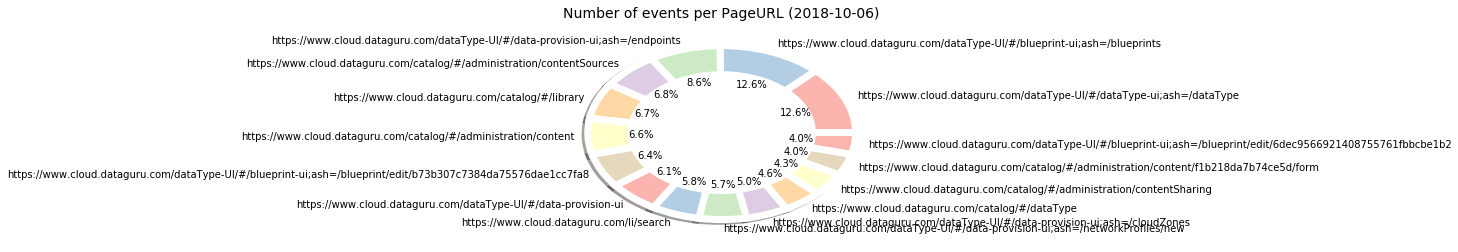

In [492]:
# AS Cell    #### I Think bar would be better here ******************

# Visually answering number of events per PageURL

# Plotting the graph
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(top_15_urls["EventCount"], labels=top_15_urls["PageUrl"], wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' }, colors=Pastel1_7.hex_colors, autopct="%1.1f%%", shadow=True)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title(f'Number of events per PageURL ({datetime.now().date()})', fontsize=14)

# Save Figure
plt.savefig("../imgs/NoOfEventsPerPageUrl.png")
plt.show()

In [459]:
### no of event count for each event per page by company/Domain
top15_urlList = []
top15_urlList = top_15_urls["PageUrl"]
df_top_urls = external_customers_df[external_customers_df.PageUrl.isin(top15_urlList)]
gpb_pages_event = df_top_urls.groupby([ "PageUrl", "EventType"])["EventStart"].count()

page_events_df = pd.DataFrame(gpb_pages_event)
page_events_df = page_events_df.rename(columns={"EventStart": "EventCount"}) #reset_index()
page_events_df = page_events_df.sort_values(['PageUrl', 'EventCount'],ascending=[False, False])

page_events_df

## Stack colored bar

EventCount
PageUrl                                            EventType            
https://www.cloud.dataguru.com/li/search           click             428
                                                   change            252
                                                   navigate          160
                                                   load               44
                                                   thrash              1
https://www.cloud.dataguru.com/dataType-UI/#/da... click            1268
                                                   navigate          528
                                                   change            136
                                                   load                4
https://www.cloud.dataguru.com/dataType-UI/#/da... click             649
                                                   change            177
                                                   navigate           53
                                                   abandon             1
https://www.cloud.dataguru.com/dataType-UI/#/da... click             705
                                                   navigate          526
                                                   change             90
                                                   load                2
                                                   abandon             1
https://www.cloud.dataguru.com/dataType-UI/#/da... click             399
                                                   navigate          346
                                                   change             24
                                                   load                2
                                                   abandon             1
https://www.cloud.dataguru.com/dataType-UI/#/da... navigate          695
                                                   load              229
                                                   click               8
                                                   abandon             1
https://www.cloud.dataguru.com/dataType-UI/#/bl... click            1215
                                                   navigate          472
                                                   change            245
                                                   load                3
https://www.cloud.dataguru.com/dataType-UI/#/bl... click             641
                                                   change            282
                                                   navigate           62
https://www.cloud.dataguru.com/dataType-UI/#/bl... click             441
                                                   change            112
                                                   navigate           63
https://www.cloud.dataguru.com/catalog/#/library   click             540
                                                   navigate          322
                                                   load              115
                                                   change             58
https://www.cloud.dataguru.com/catalog/#/dataType  click             468
                                                   navigate          219
                                                   change             21
                                                   load                2
https://www.cloud.dataguru.com/catalog/#/admini... click             607
                                                   navigate          376
                                                   change             64
https://www.cloud.dataguru.com/catalog/#/admini... click             395
                                                   change            131
                                                   navigate          131
                                                   load                1
https://www.cloud.dataguru.com/catalog/#/admini... click             433
                                               

In [735]:
# AS Cell

## Now we need to answer Most Popular Service among our Active Customers
# Setting up data for Most Popuylar Service among our Active Customers
company_byservice_df = external_customers_df.groupby(["Domain", "serviceName"])["PageUrl"].count()
company_byservice_df = company_byservice_df.reset_index()
company_byservice_df = company_byservice_df.rename(columns={"PageUrl": "PageCount"})

DomainList = []
DomainList= company_bysession_df.Domain   
DomainList
company_byservice_df = company_byservice_df[company_byservice_df.Domain.isin(DomainList)]

company_byservice_df = company_byservice_df.sort_values(["Domain", "serviceName"], ascending=False)

###
company_byservice_df = company_byservice_df.reset_index()
company_byservice_df=company_byservice_df[["Domain", "serviceName","PageCount"]]

company_byservice_df

,Domain,serviceName,PageCount
0,Company9.com,SDK,2906
1,Company9.com,Data Package,5209
2,Company50.com,SDK,295
3,Company50.com,Data Package,979
4,Company46.com,Data Logging,1393
5,Company43.com,SDK,182
6,Company43.com,Data Package,2703
7,Company38.com,Data Logging,286
8,Company36.com,SDK,274
9,Company36.com,Data Package,1067


In [ ]:
# AS Cell

## Now we need to answer Most Popular Browsers with our customers 
# Checking the types of Browsers used by customers
Popular_Browser_df = external_customers_df["PageBrowser"].unique()  
# Setting data for Most Popular Browsers 
Popular_Browser_df = external_customers_df.groupby(["PageBrowser"])["Domain"].count()
Popular_Browser_df = Popular_Browser_df.sort_values(ascending=False)
Popular_Browser_df = Popular_Browser_df.reset_index()
Popular_Browser_df = Popular_Browser_df.rename(columns={"Domain": "UserCount"})
Popular_Browser_df

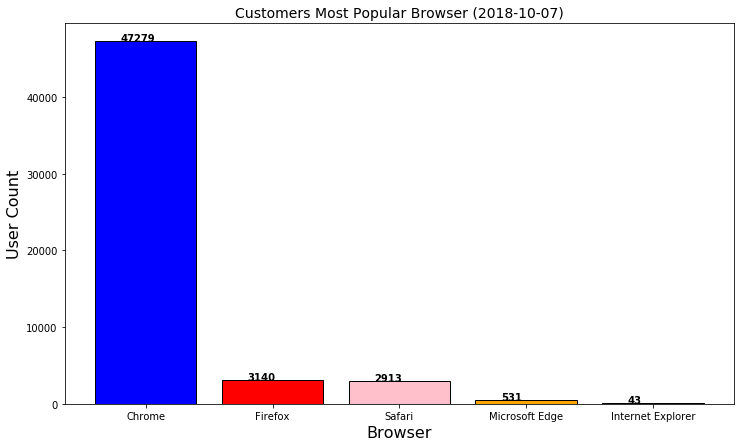

In [558]:
# AS Cell 

# Visually answering Most Popular Browser with our customers

# Plotting the graph
fig=plt.figure(figsize=(12,7))
y_pos = np.arange(len(Popular_Browser_df["PageBrowser"]))
plt.bar(y_pos, Popular_Browser_df["UserCount"], color=["Blue", "Red", "Pink", "Orange"], edgecolor='Black')

# Setting value label for each bar
for i, v in enumerate(Popular_Browser_df["UserCount"]):
    plt.text(i-.20, v+.020, v, color='black', fontweight='bold')

plt.xticks(y_pos, Popular_Browser_df["PageBrowser"])
plt.xlabel("Browser",fontsize=16)
plt.ylabel("User Count", fontsize=16)
plt.title(f'Customers Most Popular Browser ({datetime.now().date()})', fontsize=14)
# Save Figure
plt.savefig("../imgs/MostPopularBrowserBar.png")
plt.show()


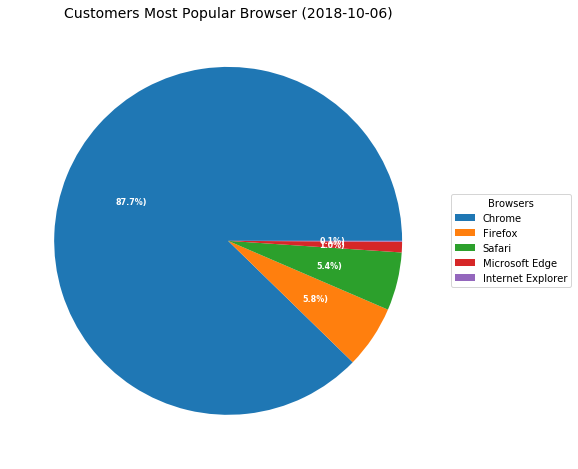

In [424]:
# AS Cell   Repeated as above, can be deleted later

# Visually answering Most Popular Browser with our customers

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(aspect="equal"))
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%)".format(pct, absolute)
wedges, texts, autotexts = ax.pie(Popular_Browser_df["UserCount"], autopct=lambda pct: func(pct, Popular_Browser_df["UserCount"]),
                                  textprops=dict(color="w"))
ax.legend(wedges, Popular_Browser_df["PageBrowser"],
          title="Browsers",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
plt.title(f'Customers Most Popular Browser ({datetime.now().date()})', fontsize=14)

# Save figure
plt.savefig("../imgs/MostPopularBrowserPie.png")
plt.show()

In [426]:
# AS Cell

## Now we need to answer Most Popular Devices used by our customers 
# Setting data for Most Popular Devices 
Popular_Device_df=external_customers_df["PageDevice"].unique()
Popular_Device_df = external_customers_df.groupby(["PageDevice"])["Domain"].count()
Popular_Device_df = Popular_Device_df.sort_values(ascending=False)
Popular_Device_df = Popular_Device_df.reset_index()
Popular_Device_df = Popular_Device_df.rename(columns={"Domain": "UserCount"})
Popular_Device_df

,PageDevice,UserCount
0,Desktop,53848
1,Mobile,33
2,Tablet,25


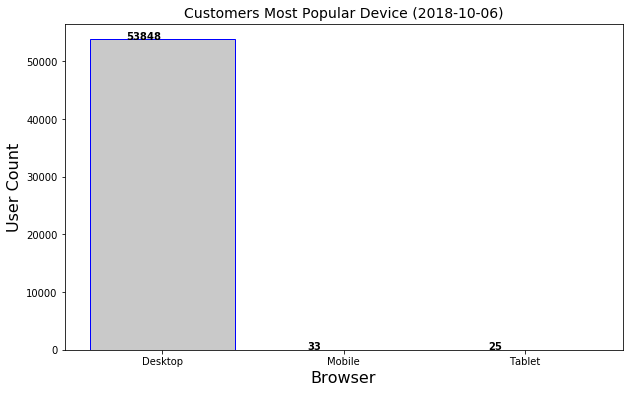

In [428]:
# AS Cell    #### We may not need this chart as does not show more or productive info visually

# Visually answering Most Popular Device used by the customer


# Plotting the graph
fig=plt.figure(figsize=(10,6))
y_pos = np.arange(len(Popular_Device_df["PageDevice"]))
plt.bar(y_pos, Popular_Device_df["UserCount"], color=(0.3, 0.3, 0.3, 0.3),  edgecolor='blue')

# Setting value label for each bar
for i, v in enumerate(Popular_Device_df["UserCount"]):
    plt.text(i-.20, v+.020, v, color='black', fontweight='bold')

plt.xticks(y_pos, Popular_Device_df["PageDevice"])
plt.xlabel("Browser",fontsize=16)
plt.ylabel("User Count", fontsize=16)
plt.title(f'Customers Most Popular Device ({datetime.now().date()})', fontsize=14)

# Save Figure
plt.savefig("../imgs/MostPopularDeviceBar.png")
plt.show()


In [756]:
#### in development : 

print(company_byservice_df.shape)  # (28, 3)

df= company_byservice_df.head(5)
UnqDomain = df["Domain"].nunique()
UnqService = df["serviceName"].nunique() # 3
df_domain= pd.DataFrame( {'Pixel': df["Domain"].unique(), 'Labels':df["Domain"].unique()})
df_serviceName=pd.DataFrame( {'Pixel': df["Domain"].unique(), 'Labels':df["serviceName"].unique()})


df_new2 = df_domains.merge(df_serviceName)
print(df_new2)



(28, 3)
Empty DataFrame
Columns: [Pixel, Labels]
Index: []
